<a href="https://colab.research.google.com/github/sarahmagdi/ITI_Reinforcement_Learning/blob/main/reinforcement_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
!pip uninstall tensorflow -y
!pip install  tensorflow==1.13.1

Found existing installation: tensorflow 1.13.1
Uninstalling tensorflow-1.13.1:
  Successfully uninstalled tensorflow-1.13.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-1.13.1-cp37-cp37m-manylinux1_x86_64.whl (92.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.7 requires tensorflow>=2.0.0, but you have tensorflow 1.13.1 which is incompatible.


# **Project** **Documentation**
within the notebook, including a detailed description of the environment (eg. observation space, action space, reward, ..., etc.), the task the agent needs to learn, your detailed implemented algorithm, and your results (training reward, evaluation mean reward and std, and a video preview of the agent after training).
# The Environment 
The environment is custom,consists of our agent "the player" and enemy and food.

*   **Observation Space:**  A 10*10 grid --> tupels(x,y)
*   **Action Space:** 9 possible actions  the four dierections besides diagonally and also no move "note that: we add the action to the current state and if it it is bigger than borders we reset to zeros"
* **Reward:** 3 different rewards as following:


>> 1.  enemy penality:
2.   move peanlity:
3. food reward:

* **The Task:** the agent suposed to reach the food in minimal steps and avoid enemy. 
* **Termination:** either the player reached the food get the reward and terminate or went to the enemy gets the penality and terminate.

# The Algorithm Deep Q Networks (DQN) Implementation 

The goal of using DQN is to reach a better velocity for the agent.
to achieve this we need two networks: <br>
* the Target Network : used to generate the label to compare with the value function of each action outputed from the training to change the loss function <br>
* the Training Network: takes an image of the state as input and generates 9 value function for each action. <br>

As result of the target Network which have the same structure of the training fuction which has an input of the **next state** from the training network based on the max value function of actions to generate the **y** and compare it to the value function of the training.<br>
use all that to update the weights of the training.<br>

we use hyperparameter of:
* epsilon for epsilon decay of: 0.99975 to prevent using only exploration but also exploitation.
* start with epsilon of 1 and minimum epsilon of 0.001.
* if we are in exploration we will use random move based on the decay equation.
* if we are in exploitation we will use the max of value function. <br>

Based on the action the agent moves to another state.<br>

Note that: not every time I give the network a state but sample it from the past 100 state in my memory.<br>

We update the weights of the target network with same training network every five epsiodes "terminate state".<br>

Teriminate is based on:
 * food reward.
 *  enemy penality.
 * exceed 200 steps.

termination causes reinitalization to continue learning.

The model is sequential model from keras consists of:
* conv layer 256 channel "filter" and the input shape is the value of the observation space. 
* the activation is a Relue function.
* maxpooling 2*2.
* dropout 0.2. 
* second conv layer of 256 and 3*3 and same structure of maxpooling od 2*2 and dropout of 0.2.
* convert the 3D feature to 1D vector using flatten 
* dense layer of 64. 
* output layer of size of action space "9"  and linear activation.
* compile loss function is  mean squaare error "mse" and Adam optimizer and a learning rate of 0.01.
* the metric is accuracy .

we normalize the batch input before getting in the Network.
We train a 500 episode through We track the minimum reward and maximum reward and the avearage reward for each episode by saving them into dictionary.

Then we test over 50 episode by following the policity the agent has learnt as we get always the max of the value function for each action and also having the maximum and minimum and average reward the agent learnt. 
* and draw the evaluation of the testing.

* dispalying an episode of the testing as we draw each state of the environment to visualize the epsiode then save it as video as output 4 and dispalying it through the colab.


```
# the Hyperparmametrs used in the training are:
DISCOUNT = 0.99
REPLAY_MEMORY_SIZE = 50_000  # How many last steps to keep for model training
MIN_REPLAY_MEMORY_SIZE = 1_000  # Minimum number of steps in a memory to start training
MINIBATCH_SIZE = 64  # How many steps (samples) to use for training
UPDATE_TARGET_EVERY = 5  # Terminal states (end of episodes)
MODEL_NAME = '2x256'
MIN_REWARD = -200  # For model save
MEMORY_FRACTION = 0.20

# Environment settings
EPISODES = 20_000

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.99975
MIN_EPSILON = 0.001

#  Stats settings
AGGREGATE_STATS_EVERY = 50  # episodes
SHOW_PREVIEW = False
```






# notes
we trained 3 agents with diffrerent random state.
* first agent with random state of 1:
min reward= -467 
max reward 21
average -181.38
* second agent 
min reward -497
max reward 25
average reward -209.94

* third agent with random state of 3:
min reward= -489 
max reward 22
average -212.38095238095238

In [1]:
import tensorflow as tf
print(tf.__version__)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

1.13.1


In [2]:
import numpy as np
import tensorflow.keras.backend as K
#import keras.backend.tensorflow_backend as backend
from tensorflow.python.keras.backend import get_session
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
from collections import deque
import time
import random
from tqdm import tqdm
import os
from PIL import Image
import cv2

In [28]:
DISCOUNT = 0.99
REPLAY_MEMORY_SIZE = 5000  # How many last steps to keep for model training
MIN_REPLAY_MEMORY_SIZE = 100  # Minimum number of steps in a memory to start training
MINIBATCH_SIZE =64   # How many steps (samples) to use for training
UPDATE_TARGET_EVERY = 5  # Terminal states (end of episodes)
MODEL_NAME = '2x256'
MIN_REWARD = -200  # For model save
MEMORY_FRACTION = 0.20

# Environment settings
EPISODES = 500

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.99975
MIN_EPSILON = 0.001

#  Stats settings
AGGREGATE_STATS_EVERY = 50  # episodes
SHOW_PREVIEW = False

In [19]:
class Blob:
    def __init__(self, size):
        self.size = size
        self.x = np.random.randint(0, size)
        self.y = np.random.randint(0, size)

    def __str__(self):
        return f"Blob ({self.x}, {self.y})"

    def __sub__(self, other):
        return (self.x-other.x, self.y-other.y)

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y

    def action(self, choice):
        '''
        Gives us 9 total movement options. (0,1,2,3,4,5,6,7,8)
        '''
        if choice == 0:
            self.move(x=1, y=1)
        elif choice == 1:
            self.move(x=-1, y=-1)
        elif choice == 2:
            self.move(x=-1, y=1)
        elif choice == 3:
            self.move(x=1, y=-1)

        elif choice == 4:
            self.move(x=1, y=0)
        elif choice == 5:
            self.move(x=-1, y=0)

        elif choice == 6:
            self.move(x=0, y=1)
        elif choice == 7:
            self.move(x=0, y=-1)

        elif choice == 8:
            self.move(x=0, y=0)

    def move(self, x=False, y=False):

        # If no value for x, move randomly
        if not x:
            self.x += np.random.randint(-1, 2)
        else:
            self.x += x

        # If no value for y, move randomly
        if not y:
            self.y += np.random.randint(-1, 2)
        else:
            self.y += y

        # If we are out of bounds, fix!
        if self.x < 0:
            self.x = 0
        elif self.x > self.size-1:
            self.x = self.size-1
        if self.y < 0:
            self.y = 0
        elif self.y > self.size-1:
            self.y = self.size-1


In [20]:
class BlobEnv:
    SIZE = 10
    RETURN_IMAGES = True
    MOVE_PENALTY = 1
    ENEMY_PENALTY = 300
    FOOD_REWARD = 25
    OBSERVATION_SPACE_VALUES = (SIZE, SIZE, 3)  # 4
    ACTION_SPACE_SIZE = 9
    PLAYER_N = 1  # player key in dict
    FOOD_N = 2  # food key in dict
    ENEMY_N = 3  # enemy key in dict
    # the dict! (colors)
    d = {1: (255, 175, 0), #middle saturated orange.
         2: (0,100,0), #darkgreen
         3: (255, 0, 0)} #red

    def reset(self):
        self.player = Blob(self.SIZE)
        self.food = Blob(self.SIZE)
        while self.food == self.player:
            self.food = Blob(self.SIZE)
        self.enemy = Blob(self.SIZE)
        while self.enemy == self.player or self.enemy == self.food:
            self.enemy = Blob(self.SIZE)

        self.episode_step = 0

        if self.RETURN_IMAGES:
            observation = np.array(self.get_image())
        else:
            observation = (self.player-self.food) + (self.player-self.enemy)
        return observation

    def step(self, action):
        self.episode_step += 1
        self.player.action(action)

        #### MAYBE ###
        #enemy.move()
        #food.move()
        ##############

        if self.RETURN_IMAGES:
            new_observation = np.array(self.get_image())
        else:
            new_observation = (self.player-self.food) + (self.player-self.enemy)

        if self.player == self.enemy:
            reward = -self.ENEMY_PENALTY
        elif self.player == self.food:
            reward = self.FOOD_REWARD
        else:
            reward = -self.MOVE_PENALTY

        done = False
        if reward == self.FOOD_REWARD or reward == -self.ENEMY_PENALTY or self.episode_step >= 200:
            done = True

        return new_observation, reward, done

    def render(self):
        img = self.get_image()
        img = img.resize((300, 300))  # resizing so we can see our agent in all its glory.
        cv2.imshow("image", np.array(img))  # show it!
        cv2.waitKey(1)

    # FOR CNN #
    def get_image(self):
        env = np.zeros((self.SIZE, self.SIZE, 3), dtype=np.uint8)  # starts an rbg of our size
        env[self.food.x][self.food.y] = self.d[self.FOOD_N]  # sets the food location tile to green color
        env[self.enemy.x][self.enemy.y] = self.d[self.ENEMY_N]  # sets the enemy location to red
        env[self.player.x][self.player.y] = self.d[self.PLAYER_N]  # sets the player tile to blue
        img = Image.fromarray(env, 'RGB')  # reading to rgb. Apparently. Even tho color definitions are bgr. ???
        return img


In [21]:
env = BlobEnv()

In [22]:
player = Blob(300)
food = Blob(300)
enemy = Blob(300)
print(player)
print(food)
print(player-food)
player.move()
print(player-food)
player.action(2)
print(player-food)

Blob (255, 156)
Blob (101, 215)
(154, -59)
(153, -60)
(152, -59)


In [23]:
# For stats
ep_rewards = [-200]

# For more repetitive results
random.seed(1)
np.random.seed(1)
#tf.random.set_seed(1) in new version
tf.set_random_seed(1)


In [13]:
# Create models folder
if not os.path.isdir('/content/drive/MyDrive/reinforce_project/models'):
    os.makedirs('/content/drive/MyDrive/reinforce_project/models')

In [24]:
# Own Tensorboard class
class ModifiedTensorBoard(TensorBoard):

    # Overriding init to set initial step and writer (we want one log file for all .fit() calls)
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.step = 1
        self.writer = tf.summary.FileWriter(self.log_dir) #******  tf.compat.v1.summary.FileWriter(self.log_dir)

    # Overriding this method to stop creating default log writer
    def set_model(self, model):
        pass


    def _write_logs(self, logs, index):
        #with self.writer.as_default():
            for name, value in logs.items():
                tf.summary.scalar(name, value) #, step=index
                self.step += 1
                self.writer.flush()

    # Overrided, saves logs with our step number
    # (otherwise every .fit() will start writing from 0th step)
    def on_epoch_end(self, epoch, logs=None):
        self.update_stats(**logs)

    # Overrided
    # We train for one batch only, no need to save anything at epoch end
    def on_batch_end(self, batch, logs=None):
        pass

    # Overrided, so won't close writer
    def on_train_end(self, _):
        pass

    # Custom method for saving own metrics
    # Creates writer, writes custom metrics and closes writer
    def update_stats(self, **stats):
        self._write_logs(stats, self.step)


In [25]:
# Agent class
class DQNAgent:
    def __init__(self):

        # Main model
        self.model = self.create_model()

        # Target network
        self.target_model = self.create_model()
        self.target_model.set_weights(self.model.get_weights())

        # An array with last n steps for training
        self.replay_memory = deque(maxlen=REPLAY_MEMORY_SIZE)

        # Custom tensorboard object
        self.tensorboard = ModifiedTensorBoard(log_dir="logs/{}-{}".format(MODEL_NAME, int(time.time())))

        # Used to count when to update target network with main network's weights
        self.target_update_counter = 0

    def create_model(self):
        model = Sequential()

        model.add(Conv2D(256, (3, 3), input_shape=env.OBSERVATION_SPACE_VALUES))  # OBSERVATION_SPACE_VALUES = (10, 10, 3) a 10x10 RGB image.
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Conv2D(256, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))

        model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
        model.add(Dense(64))

        model.add(Dense(env.ACTION_SPACE_SIZE, activation='linear'))  # ACTION_SPACE_SIZE = how many choices (9)
        model.compile(loss="mse", optimizer=Adam(lr=0.001), metrics=['accuracy'])
        return model

    # Adds step's data to a memory replay array
    # (observation space, action, reward, new observation space, done)
    def update_replay_memory(self, transition):
        self.replay_memory.append(transition)

    # Trains main network every step during episode
    def train(self, terminal_state, step):

        # Start training only if certain number of samples is already saved
        if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
            return

        # Get a minibatch of random samples from memory replay table
        minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

        # Get current states from minibatch, then query NN model for Q values
        current_states = np.array([transition[0] for transition in minibatch])/255
        current_qs_list = self.model.predict(current_states)

        # Get future states from minibatch, then query NN model for Q values
        # When using target network, query it, otherwise main network should be queried
        new_current_states = np.array([transition[3] for transition in minibatch])/255
        future_qs_list = self.target_model.predict(new_current_states)

        X = []
        y = []

        # Now we need to enumerate our batches
        for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):

            # If not a terminal state, get new q from future states, otherwise set it to 0
            # almost like with Q Learning, but we use just part of equation here
            if not done:
                max_future_q = np.max(future_qs_list[index])
                new_q = reward + DISCOUNT * max_future_q
            else:
                new_q = reward

            # Update Q value for given state
            current_qs = current_qs_list[index]
            current_qs[action] = new_q

            # And append to our training data
            X.append(current_state)
            y.append(current_qs)

        # Fit on all samples as one batch, log only on terminal state
        self.model.fit(np.array(X)/255, np.array(y), batch_size=MINIBATCH_SIZE, verbose=0, shuffle=False, callbacks=[self.tensorboard] if terminal_state else None)

        # Update target network counter every episode
        if terminal_state:
            self.target_update_counter += 1

        # If counter reaches set value, update target network with weights of main network
        if self.target_update_counter > UPDATE_TARGET_EVERY:
            self.target_model.set_weights(self.model.get_weights())
            self.target_update_counter = 0

    # Queries main network for Q values given current observation space (environment state)
    def get_qs(self, state):
        return self.model.predict(np.array(state).reshape(-1, *state.shape)/255)[0]


In [26]:
agent = DQNAgent()

## **training on 500 episode**

In [29]:
# Iterate over episodes
aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}
for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):

    # Update tensorboard step every episode
    agent.tensorboard.step = episode

    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1

    # Reset environment and get initial state
    current_state = env.reset()

    # Reset flag and start iterating until episode ends
    done = False
    while not done:

        # This part stays mostly the same, the change is to query a model for Q values
        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(agent.get_qs(current_state))
        else:
            # Get random action
            action = np.random.randint(0, env.ACTION_SPACE_SIZE)

        new_state, reward, done = env.step(action)

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

        if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
            env.render()

        # Every step we update replay memory and train main network
        agent.update_replay_memory((current_state, action, reward, new_state, done))
        agent.train(done, step)

        current_state = new_state
        step += 1

    # Append episode reward to a list and log stats (every given number of episodes)
    ep_rewards.append(episode_reward)
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        aggr_ep_rewards['ep'].append(episode)
        aggr_ep_rewards['avg'].append(average_reward)
        aggr_ep_rewards['max'].append(max_reward)
        aggr_ep_rewards['min'].append(min_reward)
        agent.tensorboard.update_stats(reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon)

        # Save model, but only when min reward is greater or equal a set value
        if min_reward >= MIN_REWARD:
            agent.model.save(f'/content/drive/MyDrive/reinforce_project/models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.model')

    # Decay epsilon
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)

100%|##########| 500/500 [1:17:26<00:00,  9.29s/episodes]


# **evaluation reward in training**

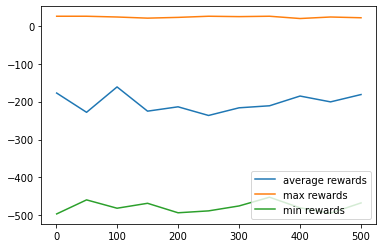

In [30]:
#evaluation reward in training
import matplotlib.pyplot as plt
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['avg'], label="average rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['max'], label="max rewards")
plt.plot(aggr_ep_rewards['ep'], aggr_ep_rewards['min'], label="min rewards")
plt.legend(loc=4)
plt.show()

In [31]:
min_reward

-467

In [32]:
max_reward

21

In [33]:
average_reward

-181.38

In [34]:
len(ep_rewards)

552

## **to get all rewards from log dir**

In [109]:
#to get all rewards from log dir
!tensorboard --logdir="/content/logs/"


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

# **evaluation on test using 50 episode**

In [35]:
#////////////////evaluation on test /////////////////////////
ep_rewards = []
aggr_ep_rewards_for_test = {'ep': [], 'avg': [], 'max': [], 'min': []}
for episode in tqdm(range(1,  50+ 1), ascii=True, unit='episodes'):

    # Update tensorboard step every episode
    agent.tensorboard.step = episode

    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1

    # Reset environment and get initial state
    current_state = env.reset()

    # Reset flag and start iterating until episode ends
    done = False
    while not done:

        
        
        action = np.argmax(agent.get_qs(current_state))
        
        new_state, reward, done = env.step(action)

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

        if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
            env.render()

        # Every step we update replay memory and train main network

        current_state = new_state
        step += 1

    # Append episode reward to a list and log stats (every given number of episodes)
    ep_rewards.append(episode_reward)
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        aggr_ep_rewards_for_test['ep'].append(episode)
        aggr_ep_rewards_for_test['avg'].append(average_reward)
        aggr_ep_rewards_for_test['max'].append(max_reward)
        aggr_ep_rewards_for_test['min'].append(min_reward)
    



100%|##########| 50/50 [00:22<00:00,  2.25episodes/s]


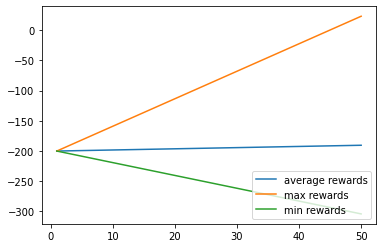

In [36]:
plt.plot(aggr_ep_rewards_for_test['ep'], aggr_ep_rewards_for_test['avg'], label="average rewards")
plt.plot(aggr_ep_rewards_for_test['ep'], aggr_ep_rewards_for_test['max'], label="max rewards")
plt.plot(aggr_ep_rewards_for_test['ep'], aggr_ep_rewards_for_test['min'], label="min rewards")
plt.legend(loc=4)
plt.show()

In [38]:
min_reward

-304

In [40]:
max_reward

23

In [41]:
average_reward

-190.42

### **diplay one episode**

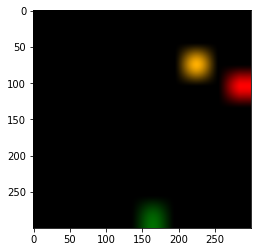

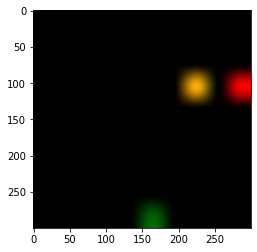

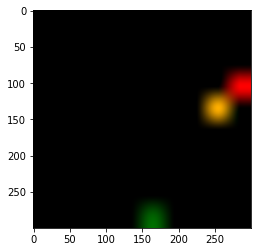

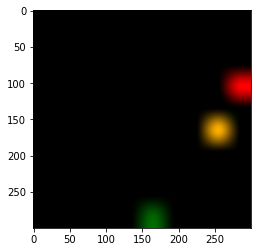

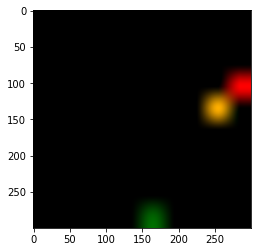

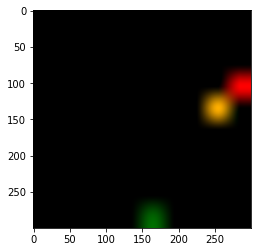

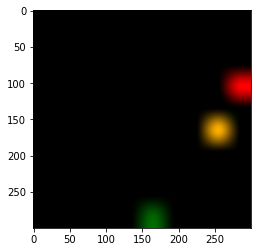

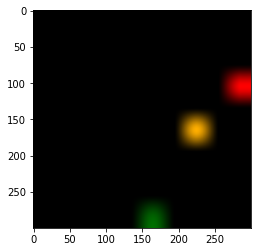

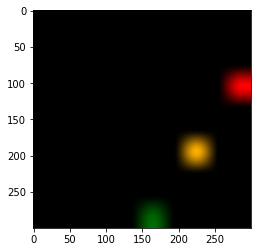

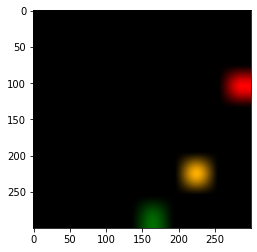

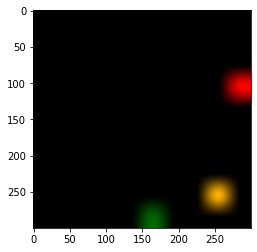

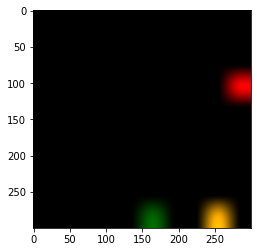

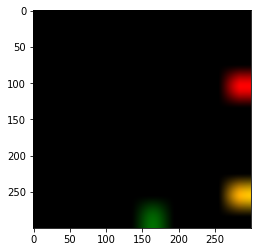

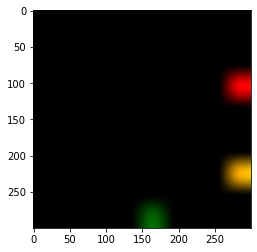

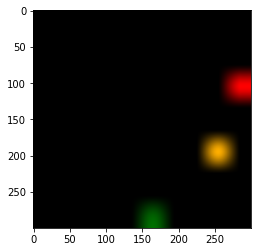

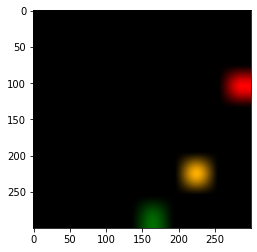

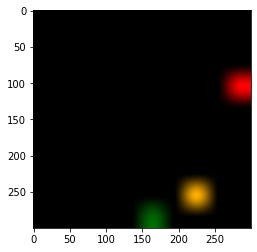

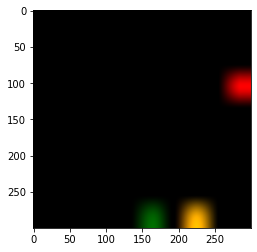

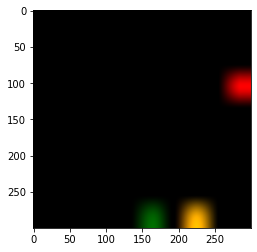

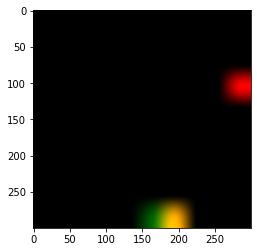

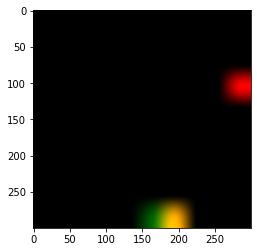

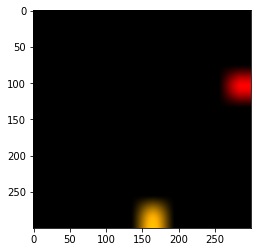

reward 5


In [ ]:
import cv2
episode_reward = 0
step = 1
current_state = env.reset()
# Reset flag and start iterating until episode ends
done = False

while not done:

        
        plt.imshow(env.get_image().resize((300, 300)))
        plt.show()
        action = np.argmax(agent.get_qs(current_state))
        
        new_state, reward, done = env.step(action)

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

        if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
            env.render()

        # Every step we update replay memory and train main network

        current_state = new_state

    # Append episode reward to a list and log stats (every given number of episodes)
plt.imshow(env.get_image().resize((300, 300)))
plt.show()
print("reward",episode_reward)

# **start state**

In [ ]:
#start state

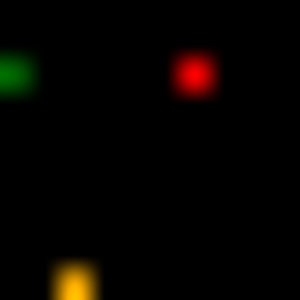

In [ ]:
env.get_image().resize((300, 300))

# **end state**

In [ ]:
#end state

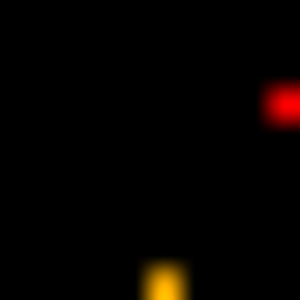

In [ ]:
env.get_image().resize((300, 300))

## **save video in one episode**

In [ ]:
#save video
import cv2
episode_reward = 0
step = 1
current_state = env.reset()
# Reset flag and start iterating until episode ends
done = False
size = (300, 300)
result = cv2.VideoWriter('/content/drive/MyDrive/reinforce_project/output4.mp4',
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         1, size)
while not done:

        
        result.write(np.array(env.get_image().resize((300, 300))))
        action = np.argmax(agent.get_qs(current_state))
        
        new_state, reward, done = env.step(action)

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

        if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
            env.render()

        # Every step we update replay memory and train main network

        current_state = new_state

    # Append episode reward to a list and log stats (every given number of episodes)


result.write(np.array(env.get_image().resize((300, 300))))
result.release()
cv2.destroyAllWindows()
print("reward",episode_reward)


reward -90


## **display saved video **

In [110]:
from IPython.display import HTML
from base64 import b64encode
 
def show_video(video_path, video_width = 300):
   
  video_file = open(video_path, "br").read() #r+bbr
 
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")
 
show_video("/content/drive/MyDrive/reinforce_project/output4.mp4")

## **learning another agent with a different initial state using random seed equal 3**

In [42]:
env2 = BlobEnv()

In [45]:
# For stats
ep_rewards2 = [-200]

# For more repetitive results
random.seed(3)
np.random.seed(3)
#tf.random.set_seed(1) in new version
tf.set_random_seed(3)


In [44]:
agent2 = DQNAgent()

In [58]:
# Iterate over episodes
aggr_ep_rewards2 = {'ep': [], 'avg': [], 'max': [], 'min': []}
for episode in tqdm(range(1, 20 + 1), ascii=True, unit='episodes'):

    # Update tensorboard step every episode
    agent2.tensorboard.step = episode

    # Restarting episode - reset episode reward and step number
    episode_reward = 0
    step = 1

    # Reset environment and get initial state
    current_state = env2.reset()

    # Reset flag and start iterating until episode ends
    done = False
    while not done:

        # This part stays mostly the same, the change is to query a model for Q values
        if np.random.random() > epsilon:
            # Get action from Q table
            action = np.argmax(agent2.get_qs(current_state))
        else:
            # Get random action
            action = np.random.randint(0, env2.ACTION_SPACE_SIZE)

        new_state, reward, done = env2.step(action)

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

        if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
            env2.render()

        # Every step we update replay memory and train main network
        agent2.update_replay_memory((current_state, action, reward, new_state, done))
        agent2.train(done, step)

        current_state = new_state
        step += 1

    # Append episode reward to a list and log stats (every given number of episodes)
    ep_rewards.append(episode_reward)
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        aggr_ep_rewards2['ep'].append(episode)
        aggr_ep_rewards2['avg'].append(average_reward)
        aggr_ep_rewards2['max'].append(max_reward)
        aggr_ep_rewards2['min'].append(min_reward)
        

        
    # Decay epsilon
    if epsilon > MIN_EPSILON:
        epsilon *= EPSILON_DECAY
        epsilon = max(MIN_EPSILON, epsilon)

100%|##########| 20/20 [02:32<00:00,  7.60s/episodes]


In [60]:
average_reward

-212.38095238095238

In [61]:
min_reward

-489

In [62]:
max_reward

22

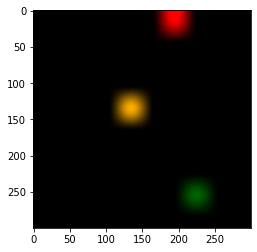

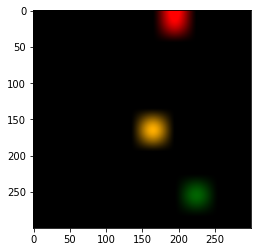

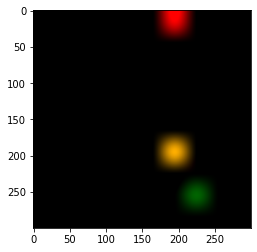

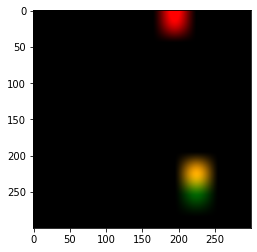

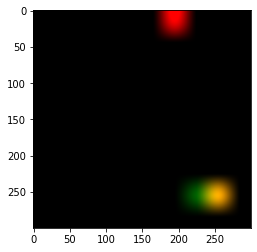

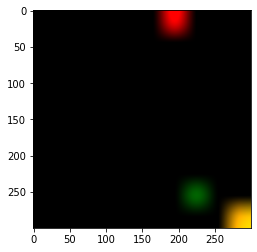

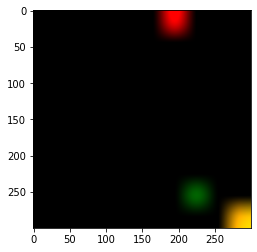

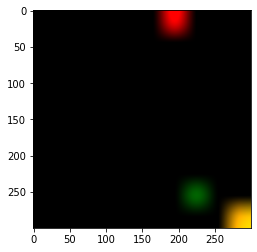

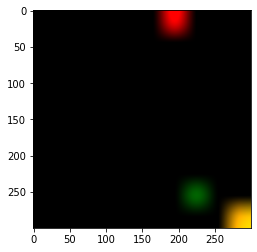

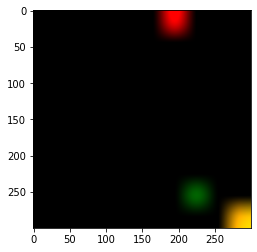

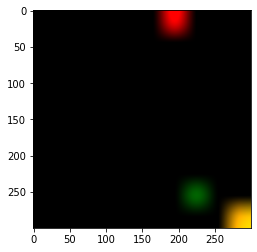

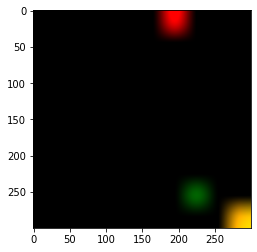

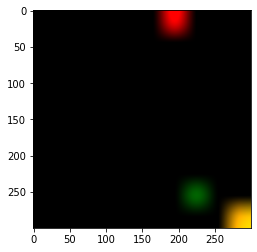

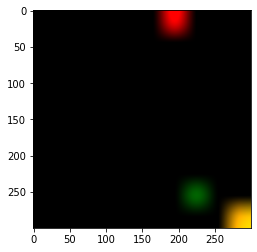

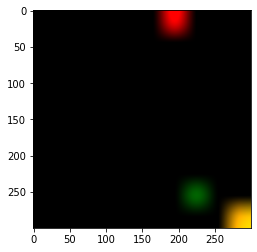

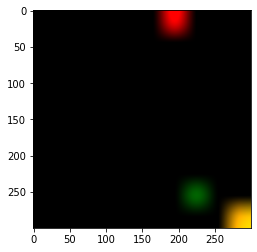

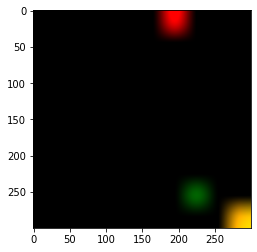

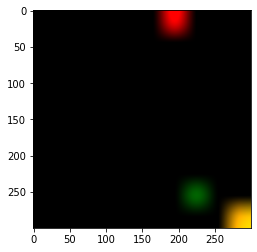

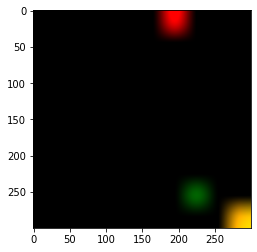

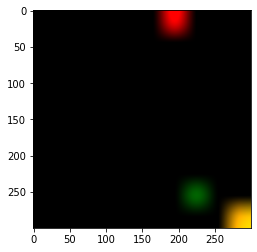

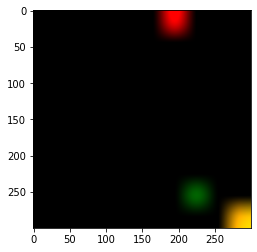

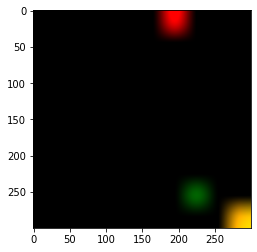

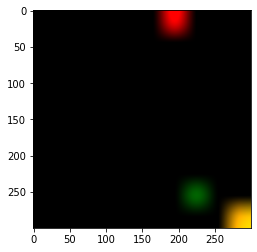

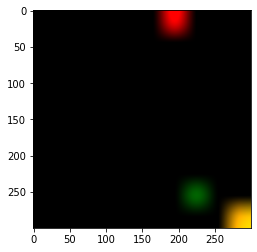

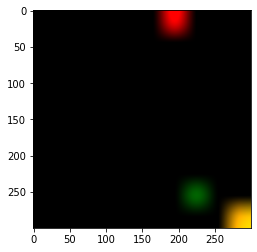

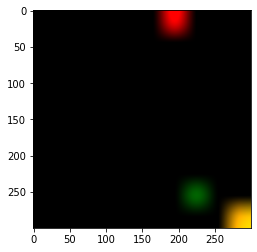

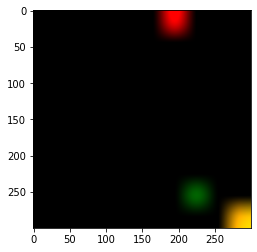

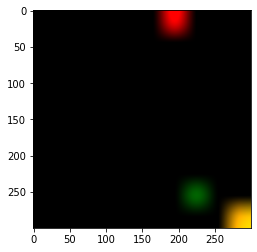

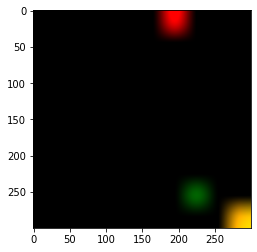

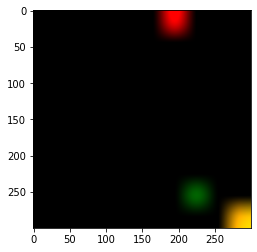

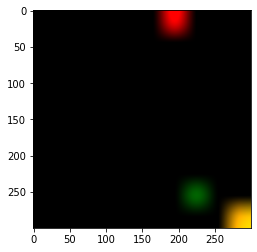

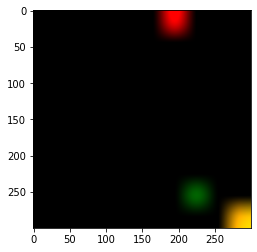

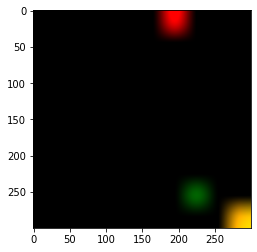

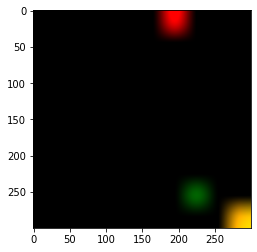

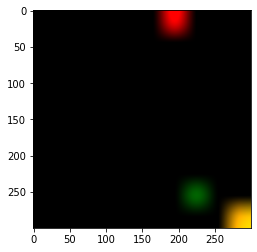

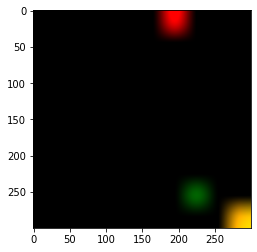

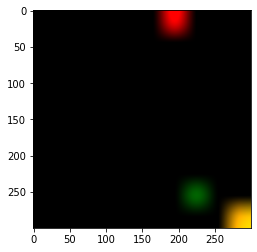

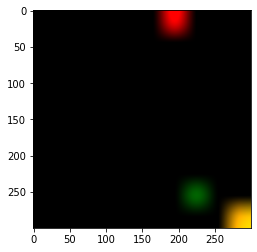

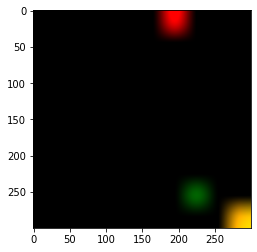

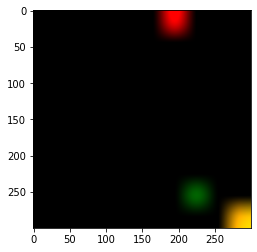

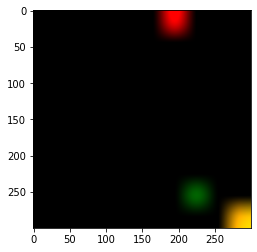

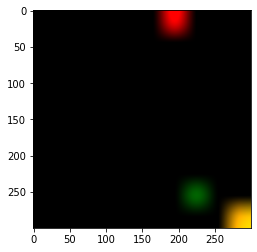

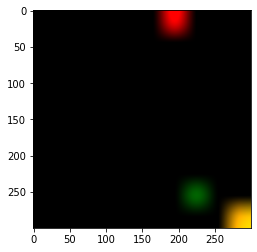

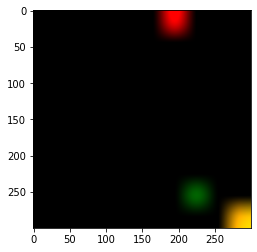

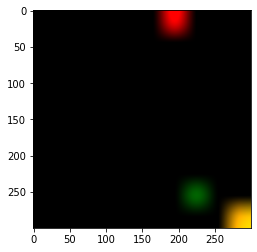

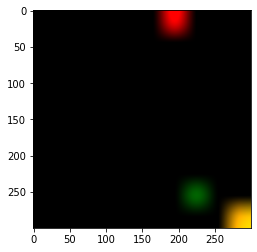

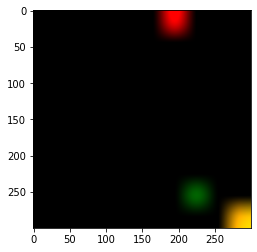

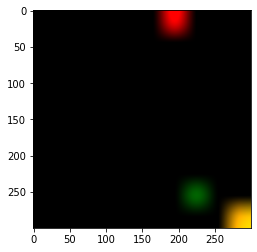

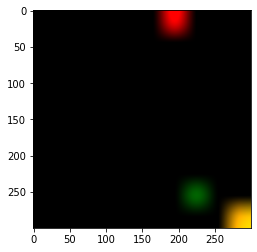

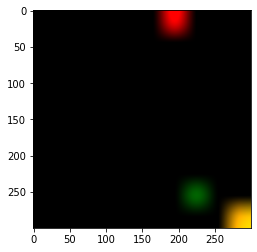

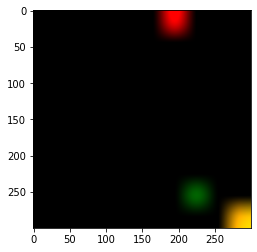

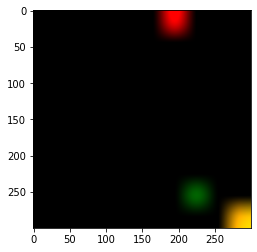

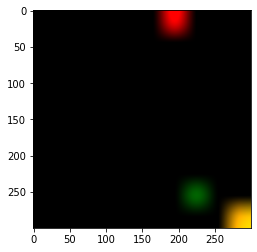

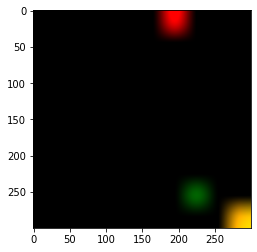

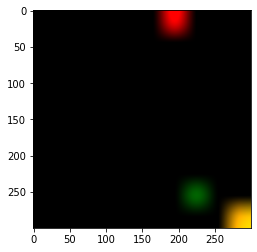

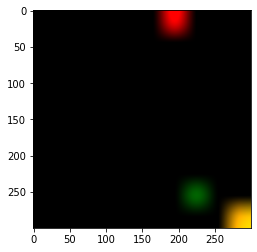

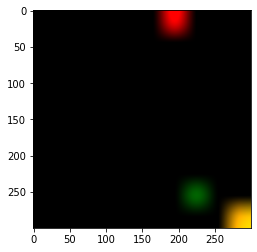

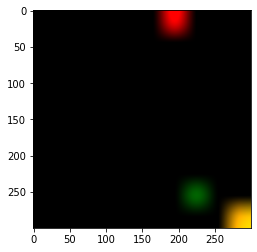

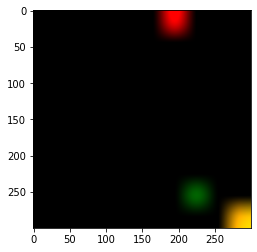

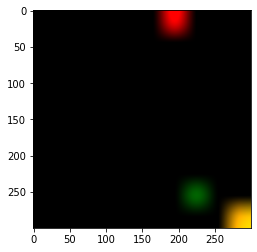

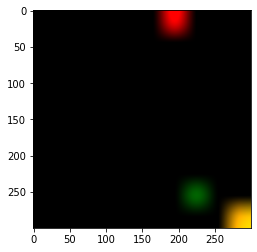

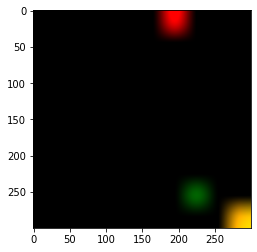

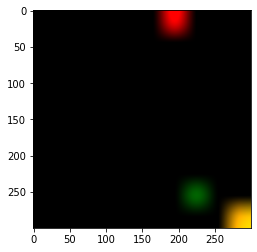

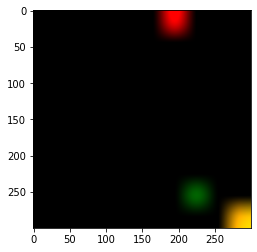

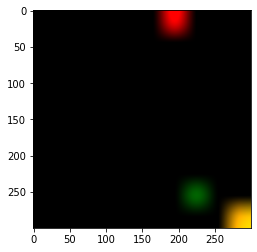

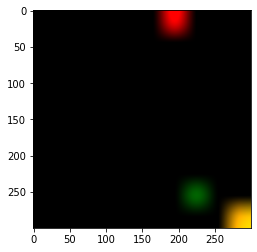

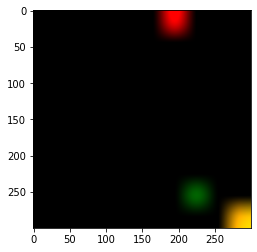

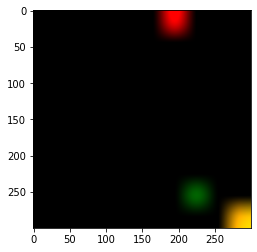

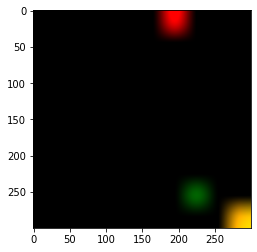

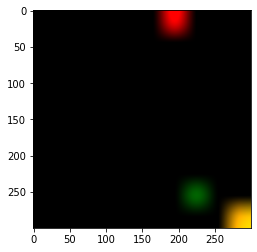

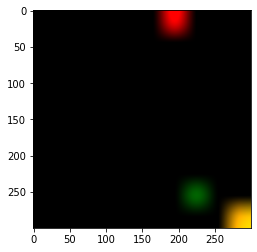

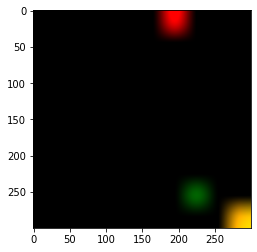

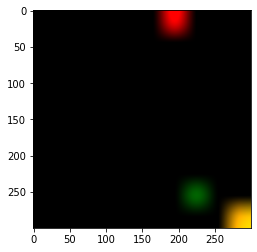

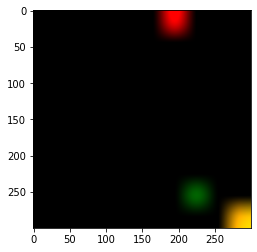

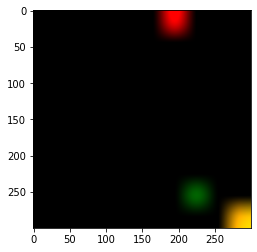

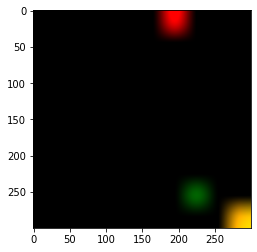

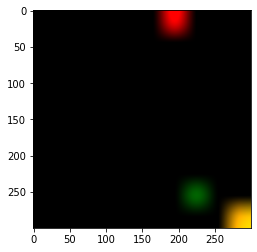

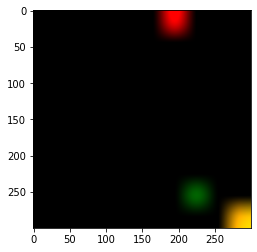

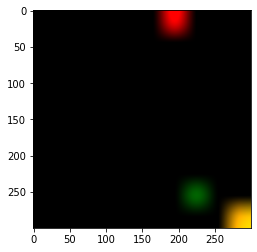

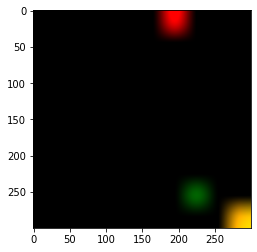

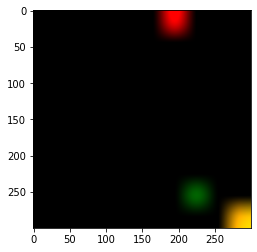

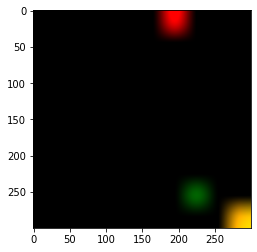

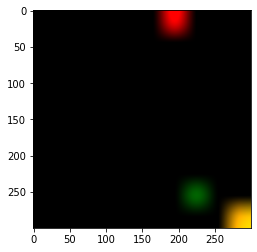

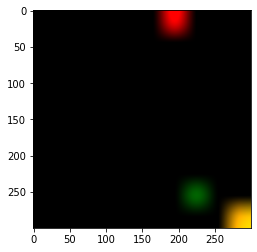

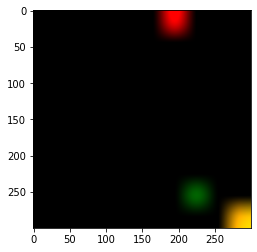

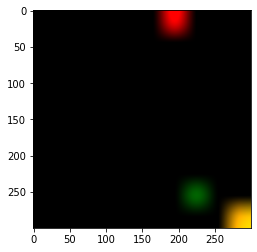

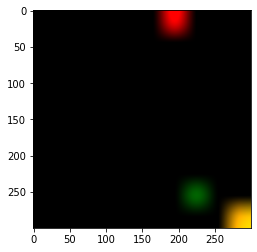

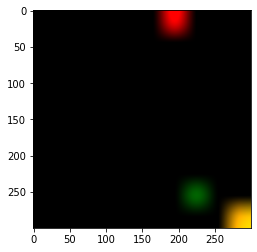

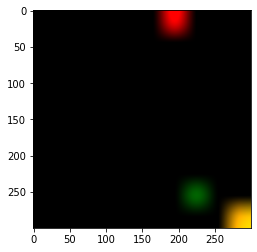

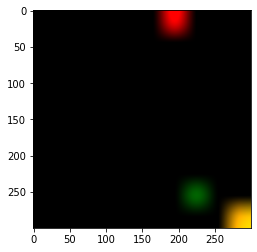

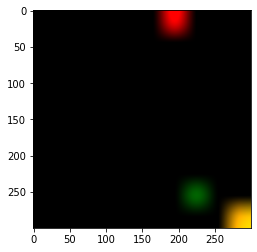

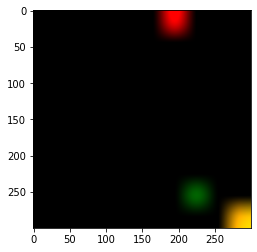

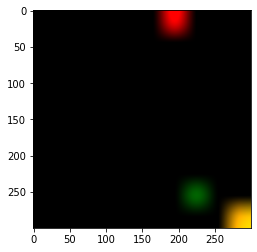

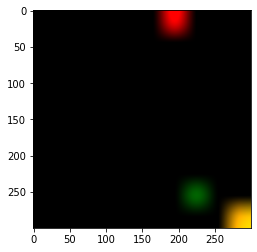

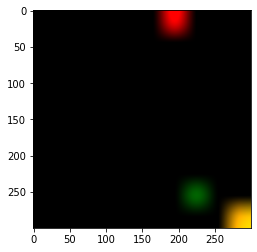

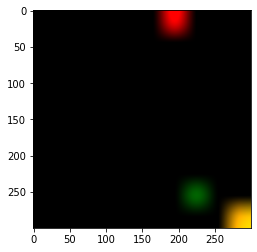

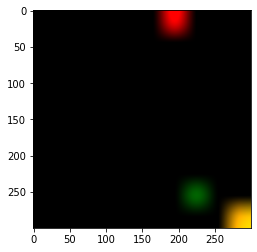

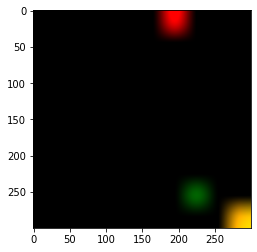

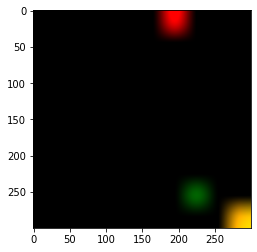

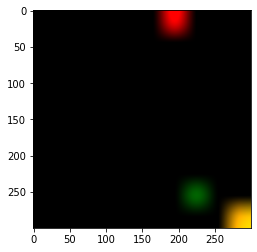

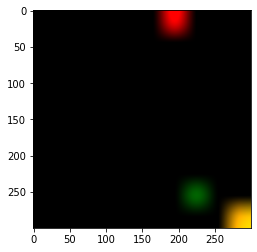

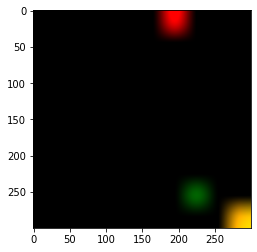

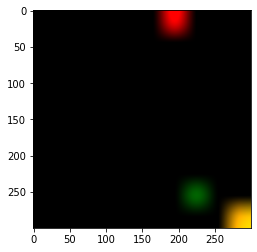

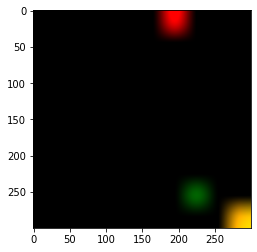

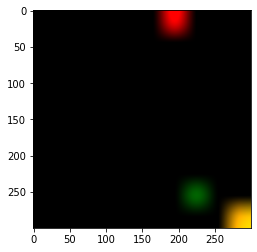

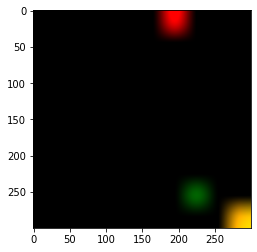

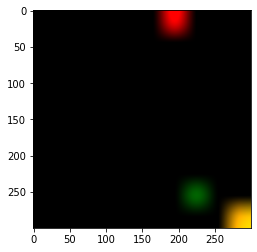

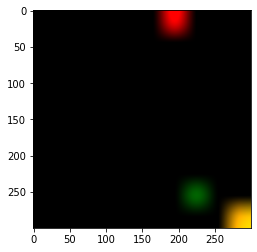

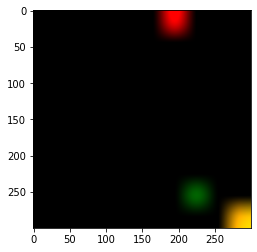

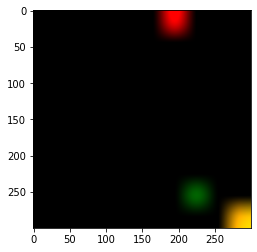

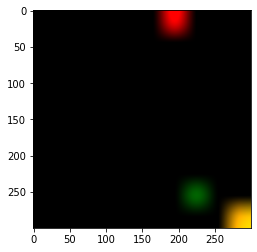

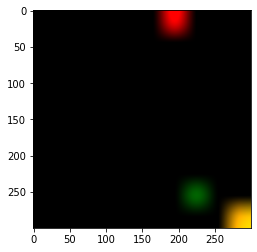

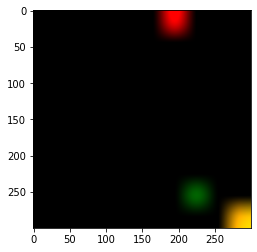

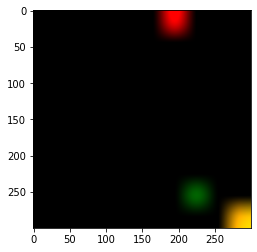

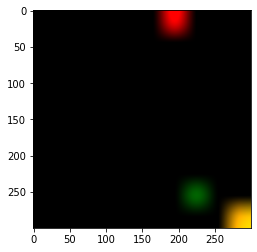

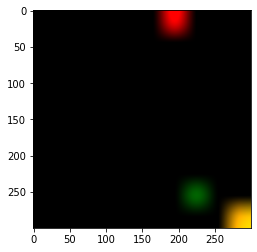

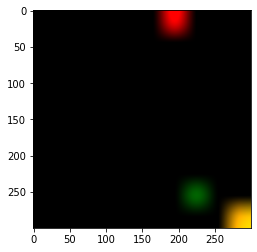

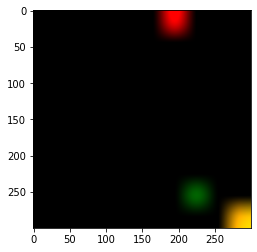

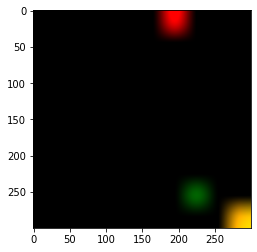

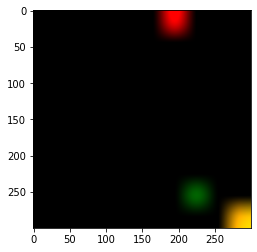

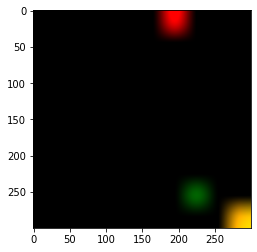

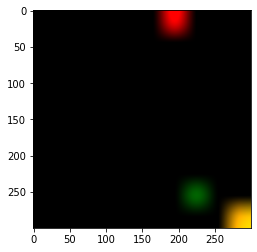

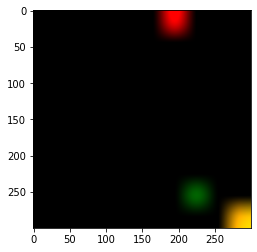

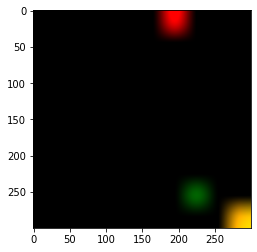

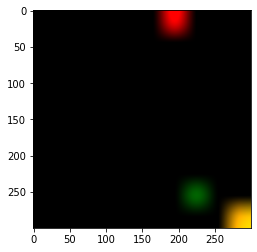

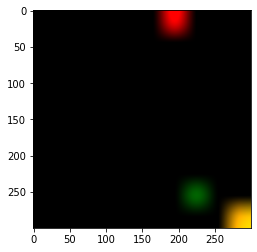

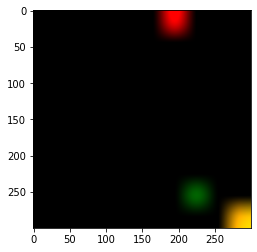

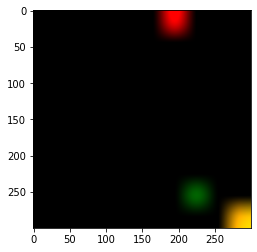

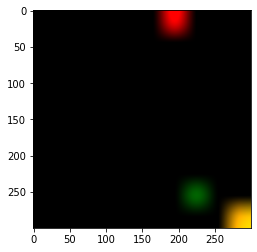

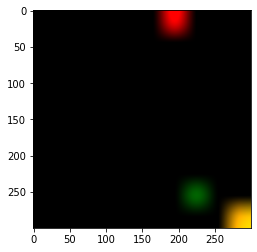

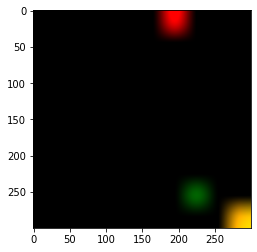

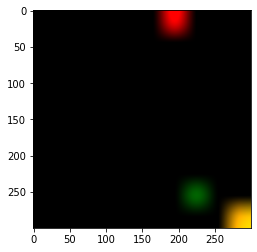

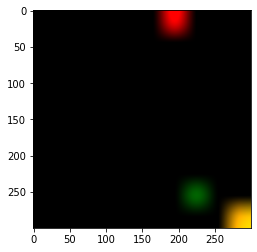

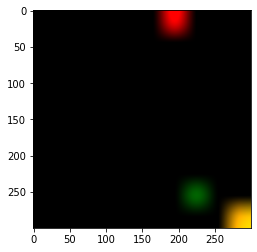

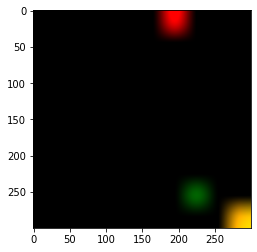

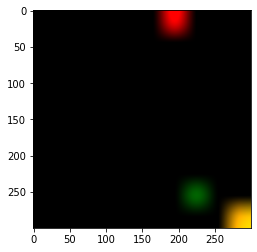

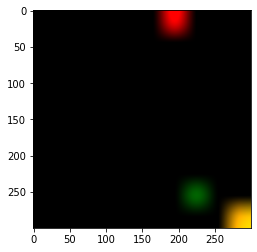

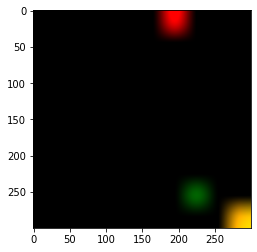

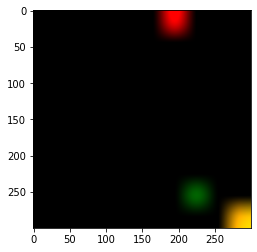

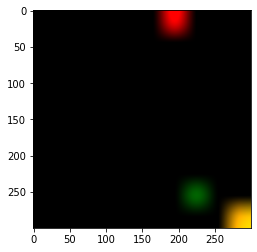

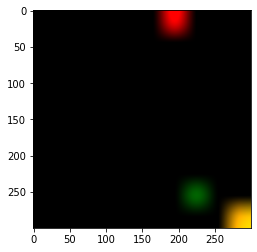

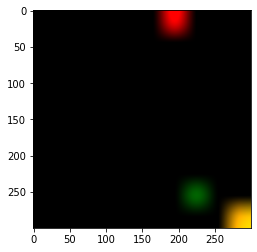

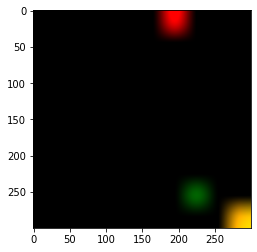

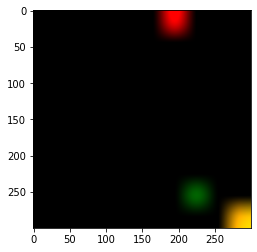

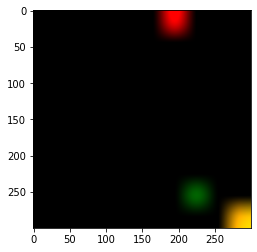

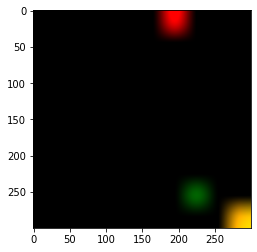

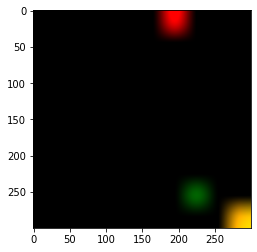

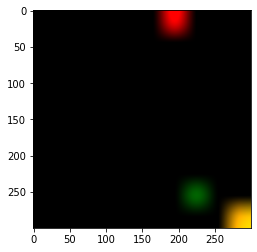

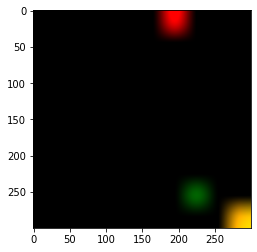

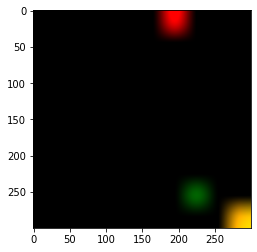

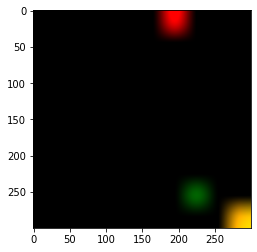

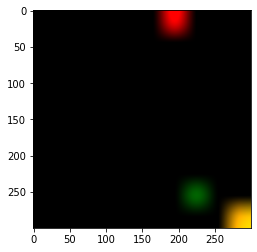

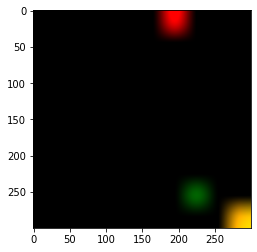

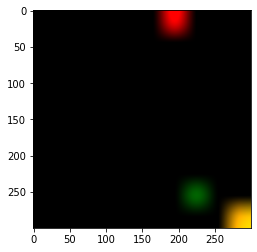

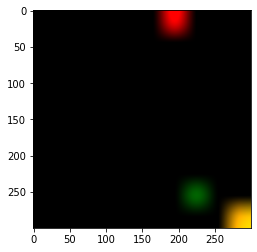

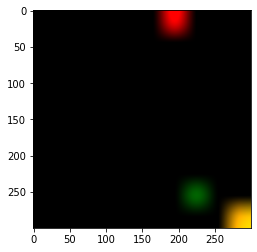

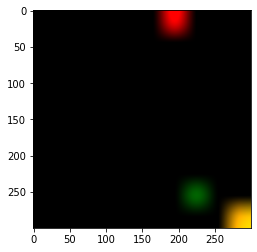

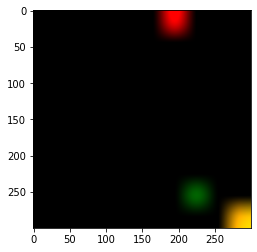

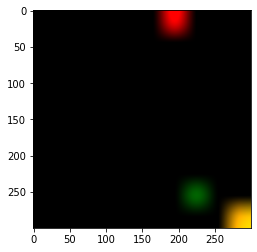

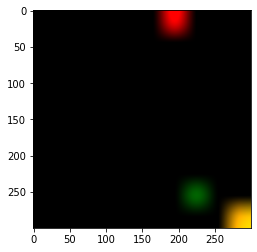

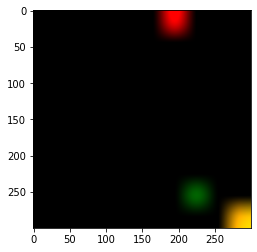

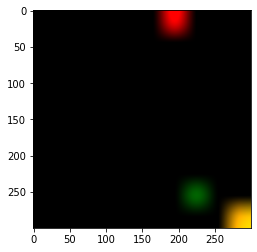

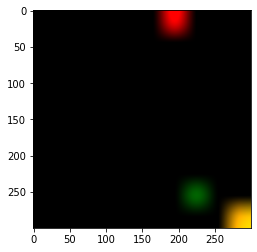

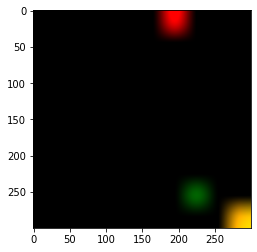

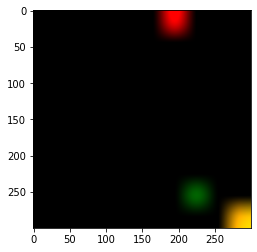

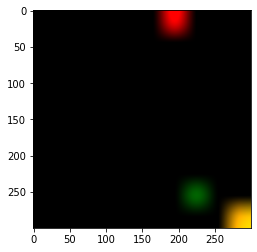

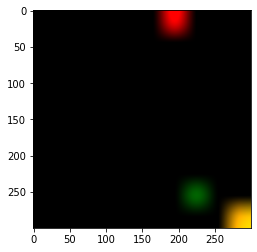

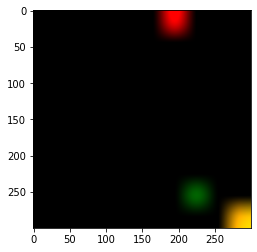

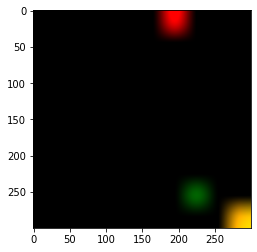

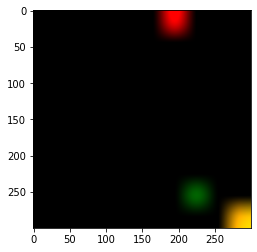

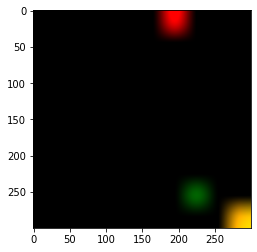

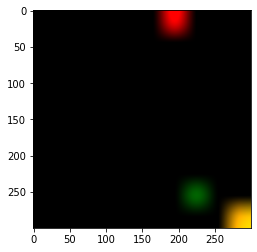

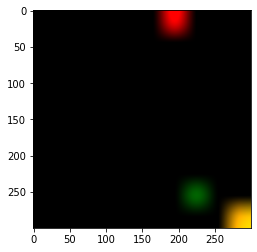

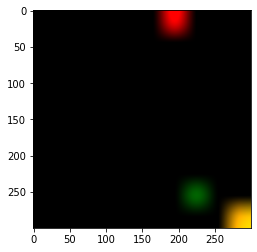

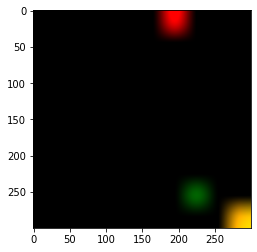

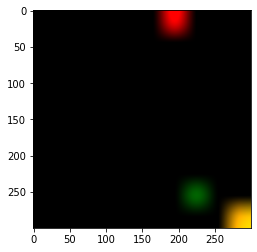

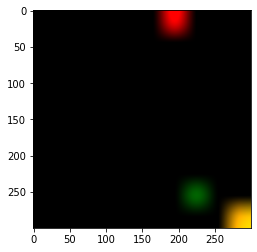

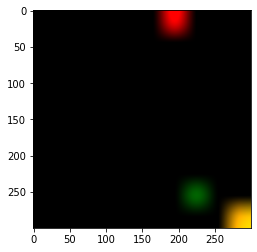

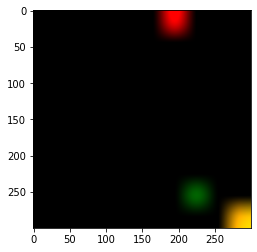

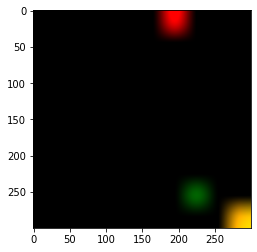

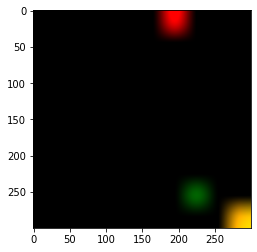

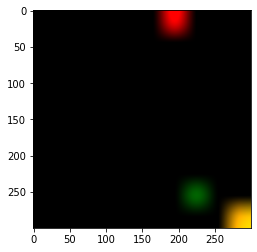

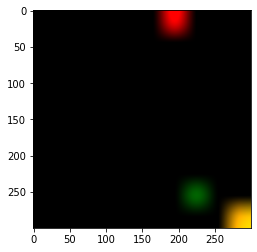

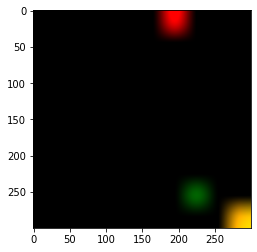

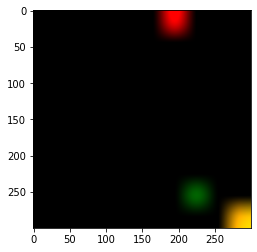

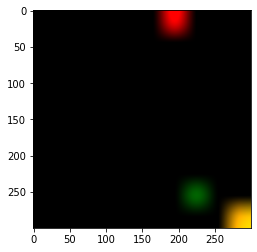

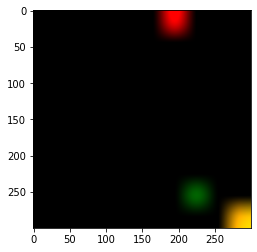

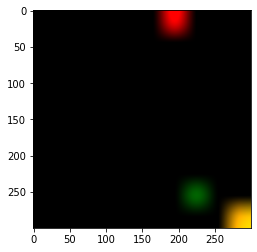

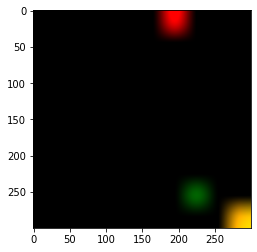

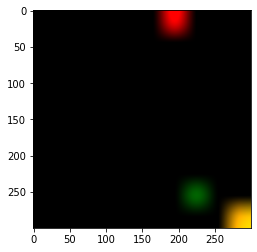

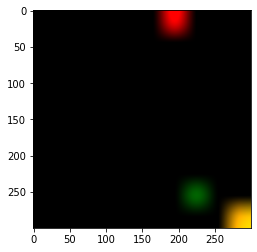

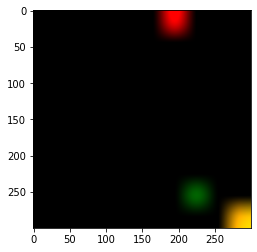

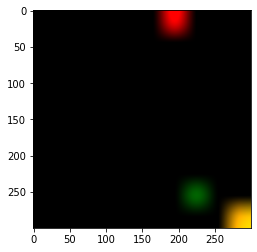

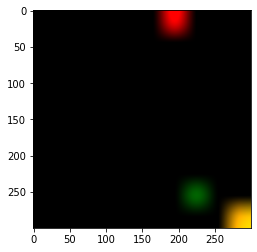

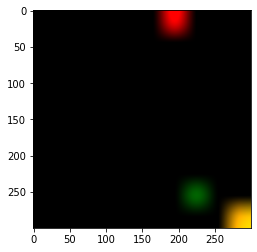

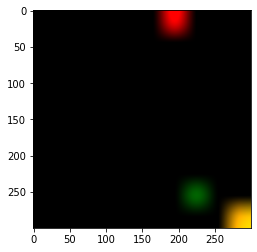

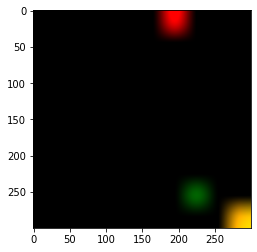

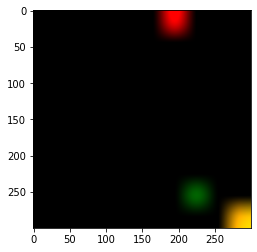

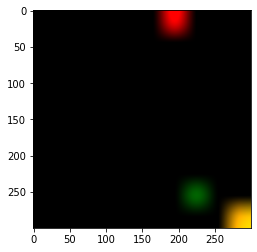

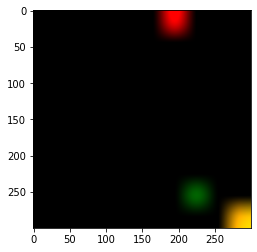

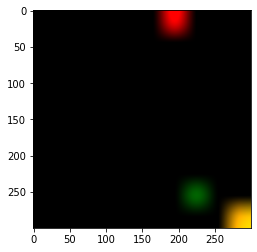

reward -200


In [63]:
import cv2
episode_reward = 0
step = 1
current_state = env2.reset()
# Reset flag and start iterating until episode ends
done = False

while not done:

        
        plt.imshow(env2.get_image().resize((300, 300)))
        plt.show()
        action = np.argmax(agent2.get_qs(current_state))
        
        new_state, reward, done = env2.step(action)

        # Transform new continous state to new discrete state and count reward
        episode_reward += reward

        if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
            env.render()

        # Every step we update replay memory and train main network

        current_state = new_state

    # Append episode reward to a list and log stats (every given number of episodes)
plt.imshow(env2.get_image().resize((300, 300)))
plt.show()
print("reward",episode_reward)